In [1]:
# Import data set 
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [3]:
colordata = '/content/gdrive/MyDrive/Project2_Imagecolorization/data' 
graydata = '/content/gdrive/MyDrive/Project2_Imagecolorization/graydata'

In [4]:
import cv2
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
#/content/blnw-images-224/bolt/00_09_0101_0100_0400_10.png
def load_images_from_folder(folder,direc,ext=["jpg","png","jpeg"]):
    # images = []
    for filename in os.listdir(folder):
      file_ext = filename.split(".")
      if len(file_ext) ==2 and file_ext[1] in ext:
        grey_img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        # save image
        status = cv2.imwrite(direc+filename,grey_img)
    return 

In [5]:
#load_images_from_folder(colordata,graydata+'/')

In [6]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = colordata
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '3500.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = graydata
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '3500.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         

100%|██████████| 3505/3505 [01:13<00:00, 47.39it/s]


In [7]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

#Plotting image pair

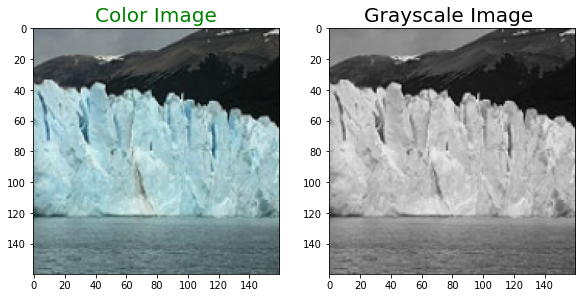

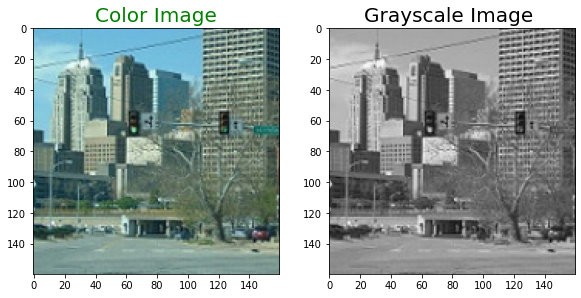

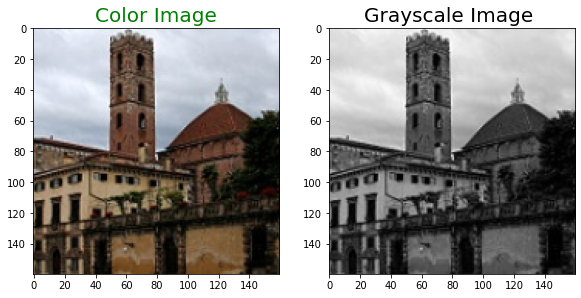

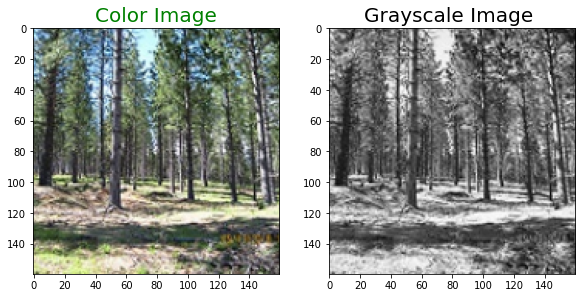

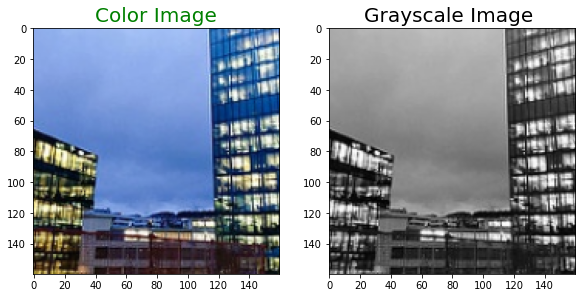

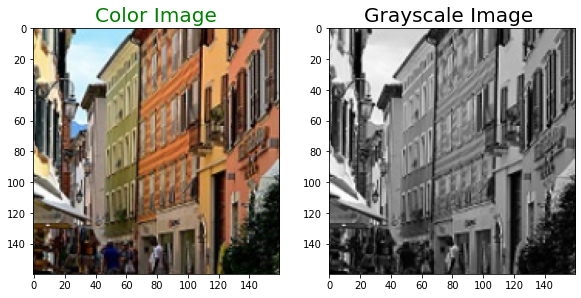

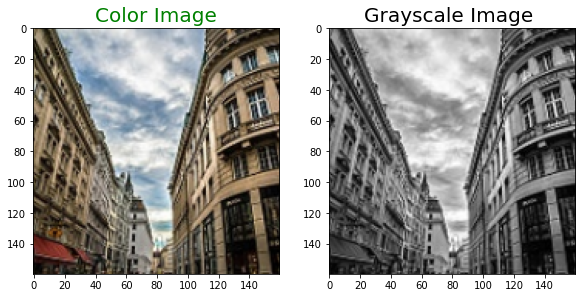

In [8]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

#Slicing and reshaping

In [14]:
train_gray_image = gray_img[:2500]
train_color_image = color_img[:2500]

test_gray_image = gray_img[2500:]
test_color_image = color_img[2500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (2500, 160, 160, 3)
Test color image shape (1005, 160, 160, 3)


#Defining our model

In [15]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [11]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [12]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

#Fitting our model

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs =50,batch_size = 50,verbose = 1)

Epoch 1/10
50/50 [==============================] - 631s 13s/step - loss: 0.1618 - acc: 0.3095
Epoch 2/10
50/50 [==============================] - 653s 13s/step - loss: 0.0832 - acc: 0.3856
Epoch 3/10
50/50 [==============================] - 649s 13s/step - loss: 0.0725 - acc: 0.4156
Epoch 4/10
50/50 [==============================] - 662s 13s/step - loss: 0.0661 - acc: 0.4255
Epoch 5/10
50/50 [==============================] - 661s 13s/step - loss: 0.0612 - acc: 0.4333
Epoch 6/10
50/50 [==============================] - 657s 13s/step - loss: 0.0581 - acc: 0.4402
Epoch 7/10
46/50 [==========================>...] - ETA: 53s - loss: 0.0551 - acc: 0.4489 

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_gray_image,test_color_image)

In [ ]:
model.save('/content/gdrive/MyDrive/Project2_Imagecolorization/model.h5')


#plotting colorized image along with grayscale and color image

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)
